### Mancala Reinforcement Learning Algorithm

**things I need:**

- an environment (mancala board)
- a policy (epsilon greedy)
- a value function (value of each state)
- a model (predicts next state and reward)

**procedure:**

- make a q network
- make a history of all states
- calculate the reward
- every 4 steps update the q network


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from enum import Enum

In [4]:
class Activation(Enum):
    RELU = 0
    SIGMOID = 1

class QLayer():
    def __init__(self, input_size : int, output_size : int, activation : Activation):
        self.output_size = output_size
        self.input_size = input_size
        self.W = np.random.rand(input_size, output_size) - 1
        self.b = np.random.rand(output_size) - 1
        self.x = None
        self.z = None
        self.a = None
        self.activation = activation
    
    def forward(self, x) -> np.ndarray:
        self.x = x
        self.z = np.dot(x, self.W) + self.b
        self.a = self.activate(self.z)
        return self.a

    def activate(self, z : np.ndarray) -> np.ndarray:
        if (self.activation == Activation.RELU):
            return np.maximum(0,z)
        elif (self.activation == Activation.SIGMOID):
            return 1 / (1 + np.exp(-z))

In [88]:
a  = np.array([[1,2,3],[4,5,6]])
a[:,2]

array([3, 6])

In [5]:

class QNetwork():
    """A simple neural network with a list of layers and a learning rate"""
    def __init__(self, layers : List[QLayer], learning_rate: float):
        self.layers = layers
        self.learning_rate = learning_rate
    
    def forward(self, a : np.ndarray ):
        """forward propagation of the network, returning the output of the last layer"""
        assert len(a) == self.layers[0].input_size
        for i in range(len(self.layers)):
            a = self.layers[i].forward(a)
        return a
    
    def backward(self, y_true: np.ndarray, y_pred: np.ndarray):
        """Backward propagation of the network, updating the weights and biases of each layer"""
        gradient : np.ndarray = (y_pred - y_true) / y_pred.size
        for layer in reversed(self.layers):
            gradient = self.gradient(gradient, layer)

    def gradient(self, gradient: np.ndarray, layer: QLayer) -> np.ndarray:
        """Calculates the gradient of the loss function with respect to the weights and biases of the layer"""
        if (layer.activation == Activation.RELU):
            gradient[layer.z <= 0] = 0
        elif layer.activation == Activation.SIGMOID:
            gradient *= layer.a * (1-layer.a)
        
        layer.W -= self.learning_rate * np.outer(layer.x, gradient)
        layer.b -= self.learning_rate * gradient

        return np.dot(layer.W, gradient)

In [83]:
class MancalaBoard():
    def __init__(self):
        self.reset()

    def reset(self):
        # self.board : np.array = np.array([4,4,4,4,4,4,0,4,4,4,4,4,4,0])
        self.board : np.array = np.array([4,4,4,4,4,4,0,4,4,4,4,4,4,0])
        self.player : int = 0
        self.turn : int = 0
        self.last_action : int = 0
        self.last_action_taken_by : int = 0
        self.gameOver : bool = False

    def __str__(self):
        game = f"Player: {self.last_action_taken_by}, Turn: {self.turn}, Action: {self.last_action}\n\n"
        game += f"Pieces: {np.sum(self.board)}\n"
        game += "________________\n"
        game += f"|      {self.board[13]}      |\n"
        for i in range(0, 6):
            game += f"|  {self.board[i]}   |   {self.board[12 - i]}  |\n"
        game += f"|      {self.board[6]}      |\n"
        game += "________________\n"
        return game

    def move(self, action : int):
        self.turn+=1
        self.last_action = action 
        self.last_action_taken_by = self.player 
        pieces : int = self.board[action]
        goal_i : int = 6 if self.player == 0 else 13
        skip : int = 13 if self.player == 0 else 6
        # move all the pieces around the board
        self.board[action] = 0
        dest_i = (action) % 14
        for i in range(pieces):
            dest_i = (dest_i + 1) % 14
            # don't put in your opponent's goal
            if (dest_i == skip):
                dest_i = (dest_i + 1) % 14
            self.board[dest_i] += 1
        # if you landed on an empty square on your side, move all pieces to your goal
        if (self.board[dest_i] == 1 and self.board[12 - dest_i] > 0 and ((dest_i < 6 and self.player == 0) or (dest_i >= 7 and dest_i < 13 and self.player == 1))):
            self.board[goal_i] += self.board[dest_i] + self.board[12-dest_i]
            self.board[dest_i] = 0
            self.board[12-dest_i] = 0
        # if you land on your goal, go again
        if (dest_i != goal_i): 
            self.player = 0 if self.player == 1 else 1
        ### game over cases ###
        # one side becomes empty
        if (np.sum(self.board[0:6]) == 0 ):
            for i in range(7,13):
                self.board[13] += self.board[i]
                self.board[i] = 0
            self.gameOver = True
        elif (np.sum(self.board[7:13]) == 0):
            for i in range(0, 6):
                self.board[6] += self.board[i]
                self.board[i] = 0
            self.gameOver = True
        # return the experience data
        return self.board.copy(), self._getReward(self.player, self.board.copy()), self.gameOver
        

    def _getReward(self, player : int, old_board : np.ndarray):
        your_score : int = self.board[13] if player == 1 else self.board[6]
        their_score : int = self.board[6] if player == 0 else self.board[13]
        if (self.gameOver):
            return 5 if your_score > their_score else -5
        else:
            your_old_score : int = old_board[13] if player == 1 else old_board[6]
            return (your_score - your_old_score)

        

        

In [84]:
from abc import ABC, abstractmethod
class Agent(ABC):
    @abstractmethod
    def decide(self, state: np.ndarray) -> int:
        pass

class Robot(Agent):
    def __init__(self, q_net : QNetwork, player : int):
        self.q_net = q_net
        self.player = player

    def decide(self, state: np.ndarray) -> int:
        # flip the board if the robot is player 1
        new_state = state.copy()
        if (self.player == 1):
            new_state[:7] = state[7:14]
            new_state[7:14] = state[:7]
        q_pred = self.q_net.forward(new_state)
        action = np.argmax(np.where(new_state[:6] > 0, q_pred, 0))
        return action if self.player == 0 else action + 7

class Human(Agent):
    def decide(self, state: np.ndarray) -> int:
        valid = False
        while not valid:
            action = int(input("Enter a move: "))
            valid = state[action] > 0
        return action

class Random(Agent):
    def decide(self, state: np.ndarray) -> int:
        valid = False
        while not valid:
            action = np.random.randint(7,13) if self.player == 1 else np.random.randint(0,6)
            valid = state[action] > 0
        return action

In [85]:
iter = 10000
max_replay = 10000
epsilon = 1.0
epsilon_decay_rate = 0.999
min_epsilon = 0.01
discount_factor = 0.99
q_net = QNetwork([QLayer(14,64,Activation.RELU),
                   QLayer(64,64,Activation.RELU),
                   QLayer(64,6,Activation.SIGMOID)],
                   learning_rate=0.01)
q_net0 = QNetwork([QLayer(14,64,Activation.RELU),
                   QLayer(64,64,Activation.RELU),
                   QLayer(64,6,Activation.SIGMOID)],
                   learning_rate=0.01)
q_net1 = QNetwork([QLayer(14,128,Activation.RELU),
                   QLayer(128,128,Activation.RELU),
                   QLayer(128,6,Activation.SIGMOID)],
                   learning_rate=0.01)
agent0 = Robot(q_net0, 0)
agent1 = Robot(q_net1, 1)

### DQN Training. One neural net. no batches. no optimizations.

iter: 0, cost: 0.015287375949344926
iter: 1000, cost: 0.002050794969990917
iter: 2000, cost: 0.005715680419080872
iter: 3000, cost: 1.8046829165715959
iter: 4000, cost: 0.011436264824069441
iter: 5000, cost: 0.01725845785930247
iter: 6000, cost: 0.010135568553163098
iter: 7000, cost: 1.6834196047949381
iter: 8000, cost: 1.7164919586927814
iter: 9000, cost: 0.05989864001401462
win ratio 0.51


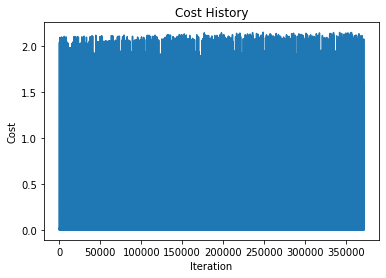

In [86]:
env = MancalaBoard()
replay_buffer = np.array([])
cost_hist = []
win_hist = []
for i in range(iter):
    env.reset()
    game_over = False
    ave_cost = 0.0
    last_action_robot = 0
    last_state_robot = np.zeros(14)
    move_count = 0
    while not game_over:
        state = env.board / 48
    # choose an action with epsilon greedy
        if (env.player == 0):
            rand_e = np.random.rand()
            q_pred = q_net.forward(state)
            if (rand_e < epsilon):
                valid_indices = np.where(state[:6] > 0)[0]
                action = np.random.choice(valid_indices)
            else:
                action = np.argmax(np.where(state[:6] > 0, q_pred, 0))
            last_action_robot = action
            # get the new state from the action
            last_state_robot = state
            new_state, reward, game_over = env.move(action)
            replay_buffer = np.append(replay_buffer, np.append(state, q_pred, action, reward, new_state, game_over))
            if (move_count % 4 == 0 and replay_buffer.size > 64):
                sample_indices = np.random.choice(replay_buffer.shape[0], 64)
                sample_experiences = replay_buffer[sample_indices]
                vfunc = np.vectorize(q_net.forward)
                q_target_sample = sample_experiences[:,3] + discount_factor * np.max(vfunc(sample_experiences[:,4]))
                q_pred_sample = np.array([x[0] for x in sample_experiences])

                q_net.backward(q_target_sample, q_pred_sample)
                # q_target = q_net.forward(last_state_robot)
                # q_target[last_action_robot] = reward + discount_factor * np.max(q_net.forward(new_state))
                # q_net.backward(q_target, q_pred)
                # q_target_max = reward + discount_factor * np.max(q_net.forward(new_state))

            cost = np.sum(np.square(q_pred - q_target)) / (2*q_pred.size)
            ave_cost += cost
            # backpropagate
            q_net.backward(q_target, q_pred)
            move_count+=1
        else:
            valid = False
            while not valid:
                action = np.random.randint(7,13)
                valid = state[action] > 0
            new_state, reward, game_over = env.move(action)
            if game_over:
                if (env.board[6] > env.board[13]):
                    reward = 5
                else:
                    reward = -5
                q_target_max = reward + discount_factor * np.max(q_net.forward(new_state))
                q_target = q_pred.copy()
                q_target[last_action_robot] = q_target_max
                q_net.backward(q_target, q_pred)
        if (game_over):
            win_hist.append(env.board[6] > env.board[13])
        epsilon = max(min_epsilon, epsilon * epsilon_decay_rate)
        cost_hist.append(ave_cost.mean())

    # iteration over
    # if (i % 10 == 0):
    if (i % 1000 == 0):
        print(f'iter: {i}, cost: {ave_cost}')

# plot winning percentage
print(f'win ratio {np.round(np.sum(win_hist) / iter, 2)}')
# plot cost_hist as a line chart
plt.plot(cost_hist)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show('cost_hist.png')


    


In [ ]:
# two opposing agents

env = MancalaBoard()
cost_hist_0 = []
cost_hist_1 = []
win_hist = []
for i in range(iter):
    env.reset()
    game_over = False
    ave_cost_0 = 0.0
    ave_cost_1 = 0.0
    last_action_0 = 0
    last_state_0 = np.zeros(14)
    last_action_1 = 0
    last_state_1 = np.zeros(14)
    last_turn = 0
    last_pred_0 = np.zeros(6)
    last_pred_1 = np.zeros(6)
    while not game_over:
        last_turn = env.player
        state = env.board if env.player == 0 else np.concatenate((env.board[7:14] , env.board[0:7]))
        # choose an action with epsilon greedy
        q_net = q_net0 if env.player == 0 else q_net1
        rand_e = np.random.rand()
        q_pred = q_net.forward(state)
        if (rand_e < epsilon):
            valid_indices = np.where(state[:6] > 0)[0]
            action = np.random.choice(valid_indices)
        else:
            action = np.argmax(np.where(state[:6] > 0, q_pred, 0))
        if (env.player == 0):
            last_action_0 = action
            last_state_0 = state
            last_pred_0 = q_pred
        else:
            last_action_1 = action
            last_state_1 = state
            last_pred_1 = q_pred
        # get the new state from the action
        new_state, reward, game_over = env.move(action if env.player == 0 else action + 7)
        new_state = new_state if last_turn == 0 else np.concatenate((new_state[7:14], new_state[0:7]))
        q_target_max = reward + discount_factor * np.max(q_net.forward(new_state))
        q_target = q_pred.copy()
        q_target[action] = q_target_max
        cost = np.sum(np.square(q_pred - q_target)) / (2*q_pred.size)
        if (last_turn  == 0):
            ave_cost_0 += cost
        else:
            ave_cost_1 += cost
        # backpropagate
        q_net.backward(q_target, q_pred)
        if game_over:
            if (env.board[6] > env.board[13]):
                reward = 5 if last_turn == 1 else -5
            else:
                reward = 5 if last_turn == 0 else -5
            q_net = q_net0 if last_turn == 1 else q_net1
            q_target_max = reward + discount_factor * np.max(q_net.forward(last_state_0 if last_turn == 1 else last_state_1))
            q_target = last_pred_0.copy() if last_turn == 1 else last_pred_1.copy()
            q_target[last_action_0 if last_turn == 1 else last_action_1] = q_target_max
            q_net.backward(q_target, q_pred)
            win_hist.append(env.board[6] > env.board[13])
    epsilon = max(min_epsilon, epsilon * epsilon_decay_rate)
    cost_hist_0.append(ave_cost_0.mean())
    cost_hist_1.append(ave_cost_1.mean())

    # iteration over
    # if (i % 10 == 0):
    if (i % 1000 == 0):
        print(f'iter: {i}, cost0: {ave_cost_0}')
        print(f'iter: {i}, cost1: {ave_cost_1}')

# plot winning percentage
print(f'q_net0 win ratio {np.round(np.sum(win_hist) / iter, 2)}')


# TODO: batch normalization
# TODO: try experience replay
# TODO: add a regularization term to the cost function
# TODO: use an optimizer (and figure out what they are)
# TODO: change to softmax activation function
# TODO: switch to cross entropy loss function
# TODO: add another nn to predict the value of the state w/soft update

    


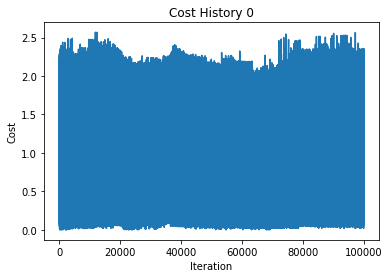

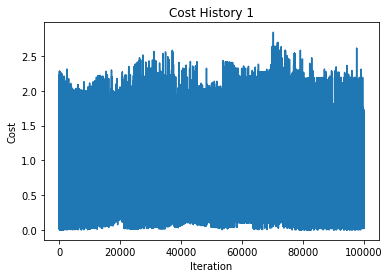

In [77]:
plt.plot(cost_hist_0)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History 0')
plt.show('cost_hist.png')
plt.plot(cost_hist_1)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History 1')
plt.show('cost_hist.png')



In [51]:
class Simulation():
    """A class to simulate a game of mancala between two agents.
    Modularly designed to allow different learning strategies plug and play."""
    def __init__(self, agent0: Agent, agent1: Agent):
        self.board = MancalaBoard()
        self.agent0 = agent0
        self.agent1 = agent1

    def _choose(self, board: np.ndarray, player : int):
        return self.agent0.decide(board) if player == 0 else self.agent1.decide(board)
    
    def play(self, verbose : bool = False):
        env = self.board
        env.reset()
        game_over = False
        while not game_over:
            action = self._choose(env.board, env.player)
            _, __, game_over = env.move(action)
            # if (verbose):
                # print(env)
        if (verbose):
            print(f"Player {0 if env.board[6] > env.board[13] else 1} won!")






In [ ]:
import time
start_time = time.time()
while time.time() - start_time < 5 * 60 * 60:
    sim = Simulation(Robot(q_net, 0), Robot(q_net, 1))
    sim.play()


In [ ]:
import numpy as np

# Neural net class 
class DQN:
    def __init__(self, state_size, action_size):
        self.W1 = np.random.rand(state_size, 128)
        self.W2 = np.random.rand(128, action_size)

    def forward(self, X):
        H = X.dot(self.W1) 
        Q = H.dot(self.W2)
        return Q

# Backprop with batches

BATCH_SIZE = 32
GAMMA = 0.95
state_size = 14
action_size = 6

env = MancalaBoard()
dqn = DQN(state_size, action_size)
replay_buffer = []

for episode in range(100):
    # Playing episode...
    env.reset()
    done = False

    while not done: 
        state = env.board
        action = env.move()
        next_state = env.board
        reward = env.reward()
        replay_buffer.append((state, action, reward, next_state))
    
    states_batch = []
    actions_batch = []
    rewards_batch = []
    
    # Gather batch  
    for experience in replay_buffer:
        states_batch.append(experience[0])
        actions_batch.append(experience[1])
        rewards_batch.append(experience[2])
        
    states = np.array(states_batch)[:BATCH_SIZE]
    actions = np.array(actions_batch)[:BATCH_SIZE]  
    rewards = np.array(rewards_batch)[:BATCH_SIZE]
    
    # Forward   
    Q = dqn.forward(states)
    
    # Calcuate loss   
    Q_a = Q[np.arange(BATCH_SIZE), actions] 
    next_Q = env.move(# Calculate for next states
    expected_Q = rewards + GAMMA * next_Q 
    
    loss = np.sum((Q_a - expected_Q) ** 2)
    
    # Backward
    dQ = Q_a - expected_Q 
    dW2 = states.T.dot(dQ)  
    dH = dQ.dot(dqn.W2.T) * (H > 0) # Relu derivative
    dW1 = states.T.dot(dH)  
    
    # Apply gradients 
    dqn.W1 -= LR * dW1  
    dqn.W2 -= LR * dW2